<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>

# Enhancing Data Science Outcomes With Efficient Workflow #

## 04 - NVTabular ##
In this lab, you will learn the motivation behind doing data science on a GPU cluster. This lab covers the ETL, data exploration, and feature engineering steps of the data processing pipeline. Extract, transform, load, or [ETL](https://en.wikipedia.org/wiki/Extract,_transform,_load), is the process where data is transformed into a proper structure for the purposes of querying and analysis. Feature engineering, on the other hand, involves the extraction and transformation of raw data. 

<p><img src='images/pipeline_overview_1.png' width=1080></p>

**Table of Contents**
<br>
In this notebook, we will use NVTabular to perform feature engineering. This notebook covers the below sections: 
1. [NVTabular](#s4-1)
    * [Multi-GPU Scaling in NVTabular with Dask](#s4-1.1)
2. [Operators](#s4-2)
3. [Feature Engineering and Preprocessing with NVTabular](#s4-3)
    * [Defining the Workflow](#s4-3.1)
    * [Exercise #1 - Using NVTabular Operators](#s4-e1)
    * [Defining the Dataset](#s4-3.2)
    * [Fit, Transform, and Persist](#s4-3.3)
    * [Exercise #2 - Load Saved Workflow](#s4-e2)

<a name='s4-1'></a>
## NVTabular ##
[NVTabular](https://nvidia-merlin.github.io/NVTabular/main/index.html) is a feature engineering and preprocessing library for tabular data that is designed to easily manipulate terabyte scale datasets. It provides high-level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS [cuDF](https://docs.rapids.ai/api/cudf/stable/) library. While NVTabular is built upon the RAPIDS cuDF library, it improves cuDF since data is not limited to GPU memory capacity. The API documentation can be found [here](https://nvidia-merlin.github.io/NVTabular/main/api.html#). 

Core features of NVTabular include: 
* Easily process data by leveraging built-in or custom operators specifically designed for machine learning algorithms
* Computations are carried out on the GPU with best practices baked into the library, allowing us to realize significant acceleration
* Provide higher-level API to greatly simplify code complexity while still providing the same level of performance
* Work on arbitrarily large datasets when used with [Dask](https://www.dask.org/)
* Minimize the number of passes through the data with [Lazy execution](https://en.wikipedia.org/wiki/Lazy_evaluation)

In doing so, NVTabular helps data scientists and machine learning engineers to: 
* Process datasets that exceed GPU and CPU memory without having to worry about scale
* Focus on what to do with the data and not how to do it by using abstraction at the operation level
* Prepare datasets quickly and easily for experimentation so that more models can be trained

Data science can be an iterative process that requires extensive repeated experimentation. The ability to perform feature engineering and preprocessing quickly translates into faster iteration cycles, which can help us to arrive at an optimal solution. 

<a name='s4-1.1'></a>
### Multi-GPU Scaling in NVTabular with Dask ###
NVTabular supports multi-GPU scaling with [Dask-CUDA](https://github.com/rapidsai/dask-cuda) and `dask.distributed`[[doc]](https://distributed.dask.org/en/latest/). For multi-GPU, NVTabular uses [Dask-cuDF](https://github.com/rapidsai/cudf/tree/main/python/dask_cudf) for internal data processing. The parallel performance can depend strongly on the size of the partitions, the shuffling procedure used for data output, and the arguments used for transformation operations. 

<a name='s4-2'></a>
## Operators ##
NVTabular has already implemented several data transformations, called `ops`[[doc]](https://nvidia-merlin.github.io/NVTabular/main/generated/nvtabular.ops.Operator.html). An `op` can be applied to a `ColumnGroup` from an overloaded `>>` operator, which in turn returns a new `ColumnGroup`. A `ColumnGroup` is a list of column names as text. 

```
features = [ column_name_1, column_name_2, ...] >> op1 >> op2 >> ...
```

Since the Dataset API can both ingest and output a Dask collection, it is straightforward to transform data either before or after an NVTabular workflow is executed. This means that some complex preprocessing operations, that are not yet supported in NVTabular, can still be accomplished with the Dask-CuDF API:

Common operators include: 
* [Categorify](https://nvidia-merlin.github.io/NVTabular/main/api/ops/categorify.html) - transform categorical features into unique integer values
    * Can apply a frequency threshold to group low frequent categories together
* [TargetEncoding](https://nvidia-merlin.github.io/NVTabular/main/api/ops/targetencoding.html) - transform categorical features into group-specific mean of each row
    * Using `kfold=1` and `p_smooth=0` is the same as disabling these additional logic
* [Groupby](https://nvidia-merlin.github.io/NVTabular/main/api/ops/groupby.html) - transform feature into the result of one or more groupby aggregations
    * **NOTE**: Does not move data between partitions, which means data should be shuffled by groupby_cols
* [JoinGroupby](https://nvidia-merlin.github.io/NVTabular/main/api/ops/joingroupby.html) - add new feature based on desired group-specific statistics of requested continuous features
    * Supported statistics include [`count`, `sum`, `mean`, `std`, `var`]. 
* [LogOp](https://nvidia-merlin.github.io/NVTabular/main/api/ops/log.html) - log transform with the continuous features
* [FillMissing](https://nvidia-merlin.github.io/NVTabular/main/api/ops/fillmissing.html) - replaces missing values with constant pre-defined value
* [Bucketize](https://nvidia-merlin.github.io/NVTabular/main/api/ops/bucketize.html) - transform continuous features into categorical features with bins based on provided bin boundaries
* [LambdaOp](https://nvidia-merlin.github.io/NVTabular/main/api/ops/lambdaop.html) - enables custom row-wise dataframe manipulations with NVTabular
* [Rename](https://nvidia-merlin.github.io/NVTabular/main/api/ops/rename.html) - rename columns
* [Normalize](https://nvidia-merlin.github.io/NVTabular/main/api/ops/normalize.html) - perform normalization using the mean standard deviation method

In [1]:
# import dependencies
import nvtabular as nvt
from nvtabular.ops import * 

from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import dask_cudf
import cudf
import gc

# instantiate a Client
cluster=LocalCUDACluster()
client=Client(cluster)

/opt/conda/envs/rapids/lib/python3.9/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/opt/conda/envs/rapids/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43087 instead
  warnings.warn(
2025-01-13 23:56:28,291 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2025-01-13 23:56:28,291 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2025-01-13 23:56:28,301 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2025-01-13 23:56:28,301 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2025-01-13 23:56:28,308 - distributed.preloading - INFO - Creating preload: dask_cuda.initia

In [2]:
# get the machine's external IP address
from requests import get

ip=get('https://api.ipify.org').content.decode('utf8')

print(f'Dask dashboard (status) is accessible on http://{ip}:8787/status')
print(f'Dask dashboard (gpu) is accessible on http://{ip}:8787/gpu')

Dask dashboard (status) is accessible on http://100.27.254.162:8787/status
Dask dashboard (gpu) is accessible on http://100.27.254.162:8787/gpu


In [3]:
# read data as Dask DataFrame
ddf=dask_cudf.read_parquet('clean_parquet')

# preview DataFrame
ddf.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,session_product,...,cat_1,cat_2,cat_3,date,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2020-03-01 04:40:41,purchase,1005126,2232732093077520756,construction.tools.light,apple,1235.550049,605335767,9d961950-c688-44fa-b904-8a5de7e63909,9d961950-c688-44fa-b904-8a5de7e63909_1005126,...,tools,light,NA,2020-03-01,4,40,6,1,3,2020
1,2020-03-01 19:52:05,purchase,12300661,2053013563743667055,appliances.kitchen.hood,crown,103.610001,608776449,bbb04b36-e6fb-480b-b04b-bc5ba0425975,bbb04b36-e6fb-480b-b04b-bc5ba0425975_12300661,...,kitchen,hood,NA,2020-03-01,19,52,6,1,3,2020
2,2020-03-01 04:47:33,purchase,1005223,2232732093077520756,construction.tools.light,xiaomi,177.339996,526590043,2524c6ba-9d5b-47ed-8120-251302557ac0,2524c6ba-9d5b-47ed-8120-251302557ac0_1005223,...,tools,light,NA,2020-03-01,4,47,6,1,3,2020
3,2020-03-01 13:44:23,purchase,1005212,2232732093077520756,construction.tools.light,samsung,171.770004,617485966,3a96f965-429f-4137-88df-fa7c8ac427ef,3a96f965-429f-4137-88df-fa7c8ac427ef_1005212,...,tools,light,NA,2020-03-01,13,44,6,1,3,2020
4,2020-03-01 19:47:01,purchase,4804056,2232732079706079299,sport.bicycle,apple,152.830002,529896062,0bfdbb1e-5d9e-49c2-8318-d072b773776e,0bfdbb1e-5d9e-49c2-8318-d072b773776e_4804056,...,bicycle,NA,NA,2020-03-01,19,47,6,1,3,2020


<a name='s4-3'></a>
## Feature Engineering and Preprocessing with NVTabular ##
The typical steps for developing with NVTabular include: 
1. Design and Define Operations in the Pipeline
2. Create Workflow
3. Create Dataset
4. Apply Workflow to Dataset

<p><img src='images/nvtabular_diagram.png' width=720></p>

<a name='s4-3.1'></a>
### Defining the Workflow ###
We start by creating the `nvtabular.workflow.workflow.Workflow`[[doc]](https://nvidia-merlin.github.io/NVTabular/main/api/workflow/workflow.html), which defines the operations and preprocessing steps that we would like to perform on the data. 

We will perform the following feature engineering and preprocessing steps: 
* Categorify the categorical features
* Log transform and normalize continuous features
* Calculate group-specific `sum`, `count`, and `mean` of the `target` for categorical features
* Log transform `price`
* Calculate `product_id` specific relative `price` to average `price`
* Target encode all categorical features

One of the key advantages of using NVTabular is the high-level abstraction we can use, which simplifies code significantly. 

In [4]:
# assign features and label
cat_cols=['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3']
cont_cols=['price', 'ts_hour', 'ts_minute', 'ts_weekday']
label='target'

In [5]:
# categorify categorical features
cat_features=cat_cols >> Categorify()

<a name='s4-e1'></a>
### Exercise #1 - Using NVTabular Operators ###
We can use the `>>` operator to specify how columns will be transformed. We need to transform the `price` feature by performing the log transformation and normalization. 

**Instructions**: <br>
* Review the documentation for the `LogOp()`[[doc]](https://nvidia-merlin.github.io/NVTabular/main/api/ops/log.html) and `Normalize()`[[doc]](https://nvidia-merlin.github.io/NVTabular/main/api/ops/normalize.html) operators. 
* Modify the `<FIXME>`s only and execute the cell below to create a workflow. 

In [7]:
# log transform 
price = (
    ['price']
    >> FillMissing(0)
    >> LogOp()
    >> Normalize()
    >> LambdaOp(lambda col: col.astype("float32"), dtype='float32')
)   

Click ... to show **solution**.

There are several ways to create a feature for relative `price` to average. We will do so with the below steps: 
1. Calculate average `price` per group. 
2. Define a function to calculate the percentage difference
3. Apply the user defined function to `price` and average `price`

In [8]:
# relative price to the average price for the product_id
# create product_id specific average price feature
avg_price_product = ['product_id'] >> JoinGroupby(cont_cols =['price'], stats=["mean"])

# create user defined function to calculate percent difference
def relative_price_to_avg(col, gdf):
    # introduce tiny number in case of 0
    epsilon = 1e-5
    col = ((gdf['price'] - col) / (col + epsilon)) * (col > 0).astype(int)
    return col

# create product_id specific relative price to average
relative_price_to_avg_product = (
    avg_price_product 
    >> LambdaOp(relative_price_to_avg, dependency=['price'], dtype='float64') 
    >> Rename(name='relative_price_product')
)

In [9]:
avg_price_category = ['category_code'] >> JoinGroupby(cont_cols =['price'], stats=["mean"])

# create product_id specific relative price to average
relative_price_to_avg_category = (
    avg_price_category 
    >> LambdaOp(relative_price_to_avg, dependency=['price'], dtype='float64') 
    >> Rename(name='relative_price_category')
)

In [10]:
# calculate group-specific statistics for categorical features
ce_features=cat_cols >> JoinGroupby(stats=['sum', 'count'], cont_cols=label)

# target encode
te_features=cat_cols >> TargetEncoding(label)

We also add the target, i.e. `label`, to the set of returned columns. We can visualize our data processing pipeline with `graphviz` by calling `.graph`. The data processing pipeline is a DAG (direct acyclic graph). 

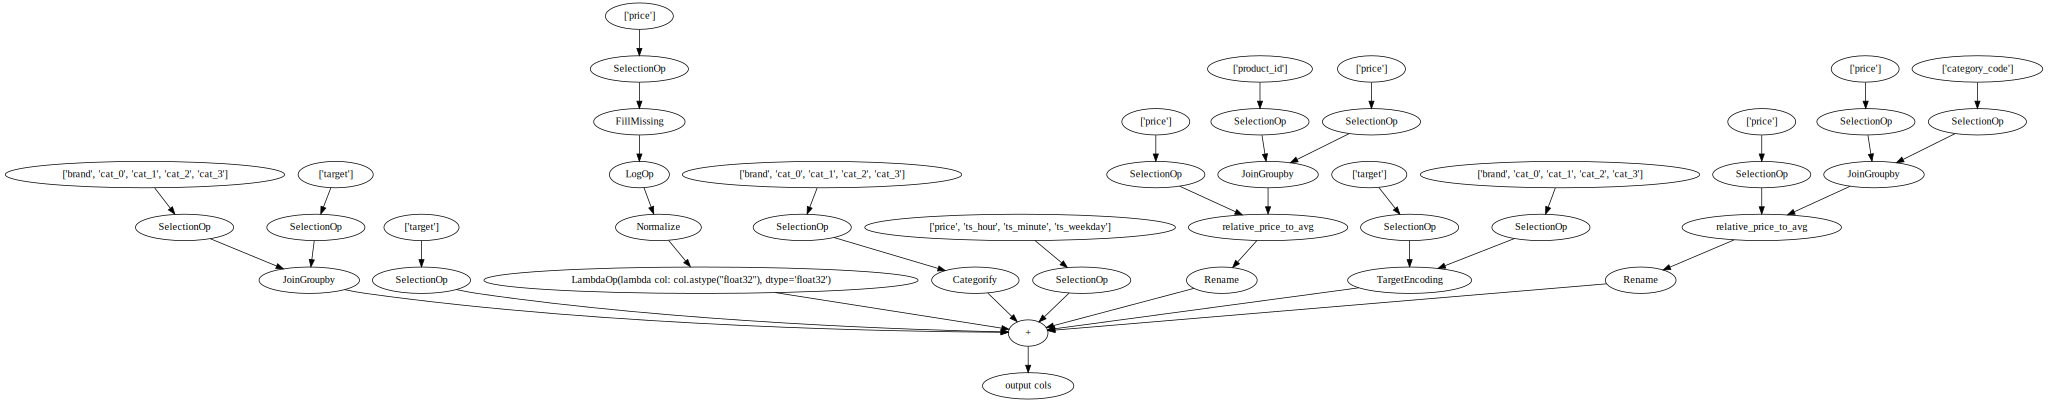

In [11]:
features=cat_features+cont_cols+ce_features+te_features+price+relative_price_to_avg_product+relative_price_to_avg_category+[label]
features.graph

We are now ready to construct a `Workflow` that will run the operations we defined above. To enable distributed parallelism, the NVTabular `Workflow` must be initialized with a `dask.distributed.Client` object. Since NVTabular already uses Dask-CuDF for internal data processing, there are no other requirements for multi-GPU scaling. 

In [12]:
# define our NVTabular Workflow with client to enable multi-GPU execution
# for multi-GPU execution, the only requirement is that we specify a client when 
# initializing the NVTabular Workflow.
workflow=nvt.Workflow(features, client=client)

/opt/conda/envs/rapids/lib/python3.9/site-packages/merlin/core/utils.py:361: FutureWarning: The `client` argument is deprecated from DaskExecutor and will be removed in a future version of NVTabular. By default, a global client in the same python context will be detected automatically, and `merlin.utils.set_dask_client` (as well as `Distributed` and `Serial`) can be used for explicit control.
  warnings.warn(


<a name='s4-3.2'></a>
### Defining the Dataset ###
All external data need to be converted to the universal `nvtabular.io.dataset.Dataset`[[doc]](https://nvidia-merlin.github.io/NVTabular/v0.7.1/api/dataset.html) type. The main purpose of this class is to abstract away the raw format of the data, and to allow other NVTabular classes to reliably materialize a `dask.dataframe.DataFrame` collection and/or collection-based iterator on demand. 

The collection-based iterator is important when working with large datasets that do not fit into GPU memory since operations in the `Workflow` often require statistics calculated across the entire dataset. For example, `Normalize` requires measurements of the dataset mean and standard deviation, and `Categorify` requires an accounting of all the unique categories a particular feature can manifest. The `Dataset` object partitions the dataset into chunks that will fit into GPU memory to compute statistics in an online fashion. 

A `Dataset` can be initialized from a variety of different raw-data formats: 
1. With a parquet-dataset directory
2. With a list of files
3. In addition to handling data stored on disk, a `Dataset` can also be initialized from an existing cuDF DataFrame, or from a `dask.dataframe.DataFrame`

The data we pass to the `Dataset` constructor is usually the result of a query from some source, for example a data warehouse or data lake. The output is usually in Parquet, ORC, or CSV format. In our case, we have the data in parquet format saved on the disk from previous steps. When initializing a `Dataset` from a directory path, the engine should be used to specify either `parquet` or `csv` format. If initializing a `Dataset` from a list of files, the engine can be inferred. 

Memory is an important consideration. The workflow will process data in chunks, therefore increasing the number of partitions will limit the memory footprint. Since we will initialize the `Dataset` with a DataFrame type (`cudf.DataFrame` or `dask.dataframe.DataFrame`), most of the parameters will be ignored and the partitions will be preserved. Otherwise, the data would be converted to a `dask.dataframe.DataFrame` with a maximum partition size of roughly 12.5% of the total memory on a single device by default. We can use the `npartitions` parameter for specifying into how many chunks we would like the data to be split. The partition size can be changed to a different fraction of total memory on a single device with the `part_mem_fraction` argument. Alternatively, a specific byte size can be specified with the `part_size` argument. 

<p><img src='images/tip.png' width=720></p>

The NVTabular dataset should be created from Parquet files in order to get the best possible performance, preferably with a row group size of around 128MB. While NVTabular also supports reading from CSV files, reading CSV can be over twice as slow as reading from Parquet. It's recommended to convert a CSV dataset into Parquet format for use with NVTabular. 

In [13]:
# create dataset
dataset=nvt.Dataset(ddf)

print(f'The Dataset is split into {dataset.npartitions} partitions')

The Dataset is split into 4 partitions


<a name='s4-3.3'></a>
### Fit, Transform, and Persist ###
NVTabular follows a familiar API for pipeline operations. We can `.fit()` the workflow to a training set to calculate the statistics for this workflow. Afterwards, we can use it to `.transform()` the training set and validation dataset. We will persist the transformed data to disk in parquet format for fast reading and train time. Importantly, we can use the `.save()`[[doc]](https://nvidia-merlin.github.io/NVTabular/main/api/workflow/workflow.html#nvtabular.workflow.workflow.Workflow.save) method so that our `Workflow` can be used during model inference. 

<p><img src='images/tip.png' width=720></p>

Since the `Dataset` API can both ingest and output a Dask collection, it is straightforward to transform data either before or after an NVTabular workflow is executed. This means that some complex pre-processing operations, that are not yet supported in NVTabular, can still be accomplished with the `dask_cudf.DataFrame` API after the `Dataset` is converted with `.to_ddf`. 

In [14]:
# fit and transform dataset
workflow.fit(dataset)
output_dataset=workflow.transform(dataset)

/opt/conda/envs/rapids/lib/python3.9/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/opt/conda/envs/rapids/lib/python3.9/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/opt/conda/envs/rapids/lib/python3.9/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/opt/conda/envs/rapids/lib/python3.9/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfu

In [15]:
# save the workflow
workflow.save('nvt_workflow')

!ls -l nvt_workflow

total 32
drwxr-xr-x 14 root root  4096 Jan 13 23:58 categories
-rw-r--r--  1 root root   187 Jan 13 23:58 metadata.json
-rw-r--r--  1 root root 21110 Jan 13 23:58 workflow.pkl


In [16]:
# remove existing parquet directory
!rm -R processed_parquet/*

# save output to parquet directory
output_path='processed_parquet'
output_dataset.to_parquet(output_path=output_path)

rm: cannot remove 'processed_parquet/*': No such file or directory


If needed, we can convert the `Dataset` object to `dask.dataframe.DataFrame` to inspect the results. 

In [17]:
# convert to DataFrame and preview
output_dataset.to_ddf().head()

,brand,cat_0,cat_1,cat_2,cat_3,ts_hour,ts_minute,ts_weekday,brand_target_sum,brand_count,...,cat_3_count,TE_brand_target,TE_cat_0_target,TE_cat_1_target,TE_cat_2_target,TE_cat_3_target,price,relative_price_product,relative_price_category,target
0,4,3,3,3,3,4,40,6,187853,390236,...,2460405,0.480502,0.482521,0.481997,0.488057,0.410012,1.679254,-0.038532,1.681901,1
1,56,4,5,37,3,19,52,6,1613,5183,...,2460405,0.303465,0.391627,0.366810,0.330639,0.410118,-0.281526,0.000185,0.267769,1
2,6,3,3,3,3,4,47,6,68194,178763,...,2460405,0.382498,0.482973,0.482485,0.488691,0.410683,0.141976,-0.061565,-0.615063,1
3,3,3,3,3,3,13,44,6,226354,457906,...,2460405,0.494479,0.482973,0.482485,0.488691,0.410683,0.116786,0.001928,-0.627154,1
4,4,8,7,4,3,19,47,6,187853,390236,...,2460405,0.481640,0.383862,0.397927,0.339425,0.410118,0.024605,-0.058324,0.269020,1


<a name='s4-e2'></a>
### Exercise #2 - Load Saved Workflow ###
We can load a saved workflow, which will contain the graph, schema, and statistics. This is useful if the workflow should be applied to future datasets. 

**Instructions**: <br>
* Review the [documentation](https://nvidia-merlin.github.io/NVTabular/main/api/workflow/workflow.html#nvtabular.workflow.workflow.Workflow.load) for the `.load()` _class_ method. 
* Modify the `<FIXME>` only and execute the cell below to create a workflow. 
* Execute the cell below to apply the graph of operators to transform the data. 

In [18]:
# load workflow
loaded_workflow=nvt.Workflow.load('nvt_workflow')

Click ... to show **solution**.

In [ ]:
# create dataset from parquet directory
dataset=nvt.Dataset('clean_parquet', engine='parquet')

# transform dataset
loaded_workflow.transform(dataset).to_ddf().head()

In [ ]:
# clean GPU memory
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

<a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a>